In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

#1. Data Collection and Pre-processing
# Load data (replace with your actual file names)
df = pd.read_csv('1. BASAL.csv')

# Creating a DataFrame from the numpy array #splitting the dataset
X = df.drop(columns=['SPAD'])  # Drop 'sample_id' and 'SPAD' to get the features
y = df['SPAD']  # Target variable

print(df)
print (X)
print(y )

# Check for missing values
print(df.isnull().sum())


      500.075    500.336    500.597    500.858    501.119    501.381  \
0    6.583333   7.472222   8.051111   7.846667   6.714444   6.973333   
1    6.281111   7.166667   7.824444   7.668889   6.552222   6.818889   
2    6.243333   7.154444   7.852222   7.733333   6.630000   6.917778   
3    7.586667   8.887778  10.127778  10.311111   9.137778   9.368889   
4    8.761111  10.051111  11.282222  11.428889  10.226667  10.410000   
..        ...        ...        ...        ...        ...        ...   
94   8.932222  10.238889  11.487778  11.673333  10.480000  10.673333   
95   7.494444   7.561111   7.492222   7.243333   6.858889   7.011111   
96   7.374444   7.472222   7.373333   7.021111   6.511111   6.628889   
97   6.687778   6.856667   6.797778   6.454444   5.890000   6.093333   
98  12.201111  13.646667  15.008889  15.252222  14.128889  14.355556   

      501.642    501.903    502.164    502.425  ...    948.856    949.094  \
0    7.746667   7.578889   6.730000   6.704444  ...  77.78

In [2]:
#Explore data statistics
df.describe()

,500.075,500.336,500.597,500.858,501.119,501.381,501.642,501.903,502.164,502.425,...,948.856,949.094,949.333,949.571,949.809,950.048,950.286,950.524,950.763,SPAD
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,6.358047,6.660348,6.906229,6.923614,6.589181,6.642817,6.932233,6.923793,6.655735,6.692088,...,46.793199,46.276801,46.420292,46.856846,46.594759,46.225432,46.272166,46.317149,45.945713,31.241313
std,2.450184,2.587438,2.737231,2.717674,2.587619,2.671072,2.801769,2.776750,2.635493,2.576869,...,21.649549,21.733446,21.727518,21.625214,21.764859,21.886222,21.869000,21.934898,22.072896,6.278641
min,2.690000,2.723333,2.723333,2.870000,2.720000,2.673333,2.893333,2.886667,2.660000,2.750000,...,20.640000,19.163333,19.550000,21.106667,20.760000,19.083333,19.643333,20.470000,18.496667,17.200000
25%,3.975000,4.091667,4.348333,4.486667,4.210000,4.120000,4.400000,4.410000,4.200000,4.238333,...,27.691667,27.560000,27.478333,27.521667,27.203333,27.225000,27.180000,26.671667,26.451667,26.650000
50%,6.325556,6.938889,7.076667,6.997778,6.502222,6.736667,6.927778,6.911111,6.540000,6.538889,...,44.620000,43.736667,43.910000,44.426667,44.073333,43.856667,44.016667,44.190000,44.123333,30.800000
75%,8.207222,8.446667,8.456667,8.441667,8.450000,8.520000,8.616667,8.648333,8.606667,8.645000,...,54.924444,54.632222,54.692778,54.938333,54.817222,54.648333,54.706111,54.753889,54.623333,37.500000
max,12.201111,13.646667,15.008889,15.252222,14.128889,14.355556,15.363333,15.263333,14.090000,13.826667,...,106.491111,106.148889,106.332222,106.667778,106.666667,106.353333,106.357778,106.508889,106.068889,42.200000


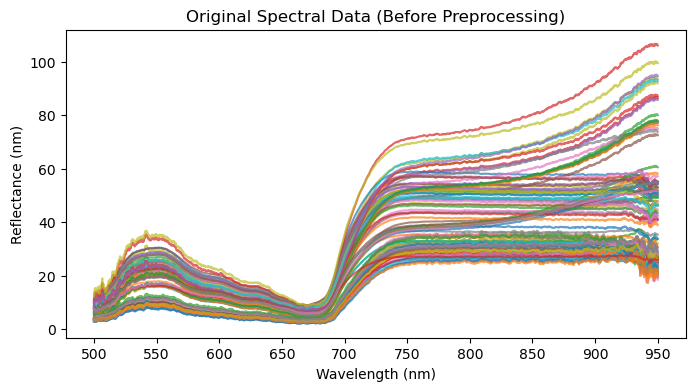

In [3]:
# Create the wavelength range from 500nm to 950nm
wavelengths = np.arange(500, 951, 50)  # Wavelengths from 500nm to 950nm with 100nm intervals
num_wavelengths = X.shape[1]  # Assuming the number of columns in X corresponds to the number of wavelengths

# Plot the spectral data
plt.figure(figsize=(8, 4))
plt.plot(X.T, alpha=0.7)

# Set x-axis labels to the wavelength values (500nm, 600nm, ..., 950nm)
plt.xticks(ticks=np.linspace(0, num_wavelengths-1, len(wavelengths)), labels=wavelengths)

# Add titles and labels
plt.title('Original Spectral Data (Before Preprocessing)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (nm)')

# Display the plot
plt.show()


In [4]:
# Step 1: Calculate Q1, Q3, and IQR for the spectral data
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Step 2: Identify outliers in the spectral data
outliers = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))

# Step 3: Create a mask to identify rows with any outliers
outlier_mask = outliers.any(axis=1)

# Step 4: Calculate the absolute deviation from the IQR boundaries for ranking
deviation = np.maximum((Q1 - X).abs(), (X - Q3).abs())

# Apply the mask to get deviations only for the identified outliers
deviation = deviation[outlier_mask]

# Step 5: Sum deviations across features for each sample (to rank overall extremeness)
total_deviation = deviation.sum(axis=1)

# Step 6: Calculate the maximum number of outliers to remove (5% of the total data)
num_samples = len(X)
max_outliers_to_remove = int(0.05 * num_samples)

# Get indices of the top 5% most extreme outliers
top_outlier_indices = total_deviation.nlargest(max_outliers_to_remove).index

# Create a new outlier mask based on the top 5% of deviations
final_outlier_mask = pd.Series(False, index=X.index)
final_outlier_mask.loc[top_outlier_indices] = True

# Step 7: Remove the top 5% most extreme outliers
cleaned_spectral_data = X[~final_outlier_mask]
cleaned_spad_data = y[~final_outlier_mask]

# Step 8: Combine the cleaned spectral data and SPAD values back into a single DataFrame (if needed)
cleaned_df = pd.concat([cleaned_spectral_data, cleaned_spad_data], axis=1)

# Step 9: Display the results
print(f"Original dataset size: {X.shape[0]}")
print(f"Number of outliers removed: {final_outlier_mask.sum()}")
print(f"Cleaned dataset size: {cleaned_df.shape[0]}")
print(f"Cleaned spectral data size: {cleaned_spectral_data.shape[0]}")

Original dataset size: 99
Number of outliers removed: 4
Cleaned dataset size: 95
Cleaned spectral data size: 95


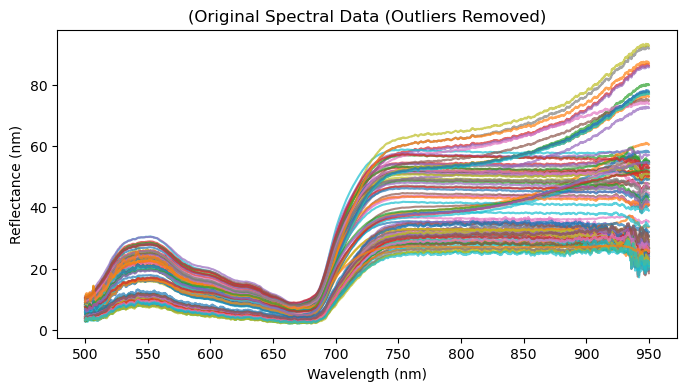

In [5]:
# Create the wavelength range from 500nm to 950nm
wavelengths = np.arange(500, 951, 50)  # Wavelengths from 500nm to 950nm with 100nm intervals
num_columns = cleaned_spectral_data.shape[1]


# Plot the spectral data
plt.figure(figsize=(8, 4))
plt.plot(cleaned_spectral_data.T, alpha=0.7)

# Set x-axis labels to the wavelength values (500nm, 600nm, ..., 950nm)
plt.xticks(ticks=np.linspace(0, num_wavelengths-1, len(wavelengths)), labels=wavelengths)

# Add titles and labels
plt.title('(Original Spectral Data (Outliers Removed)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (nm)')

# Display the plot
plt.show()

In [6]:
# Step 2: Calculate the correlation matrix for the combined DataFrame
correlation_matrix = cleaned_df.corr()

# Step 3: Extract correlations with the SPAD column (assuming the SPAD column is named 'SPAD')
correlations_with_spad = correlation_matrix['SPAD'].drop('SPAD')

# Step 4: Display the correlation values
print("Correlation values with SPAD:")
print(correlations_with_spad)

# Step 5: Sort correlations by absolute value to find strongest relationships
sorted_correlations = correlations_with_spad.abs().sort_values(ascending=False)
print("Top features correlated with SPAD:")
print(sorted_correlations.head(10))

# Step 6: Set a correlation threshold for feature selection
threshold = 0.7
mask = correlations_with_spad.abs() > threshold

# Step 7: Select features with a correlation higher than the threshold
selected_features = correlations_with_spad[mask].index
X_selected = cleaned_spectral_data[selected_features]


Correlation values with SPAD:
500.075   -0.814672
500.336   -0.777489
500.597   -0.722087
500.858   -0.699534
501.119   -0.739691
             ...   
949.809   -0.431776
950.048   -0.436707
950.286   -0.436658
950.524   -0.437425
950.763   -0.447558
Name: SPAD, Length: 1782, dtype: float64
Top features correlated with SPAD:
695.197    0.869574
695.451    0.869557
694.943    0.869090
695.706    0.868847
696.214    0.868222
694.688    0.868200
693.925    0.868135
696.468    0.868035
694.434    0.867964
693.671    0.867674
Name: SPAD, dtype: float64


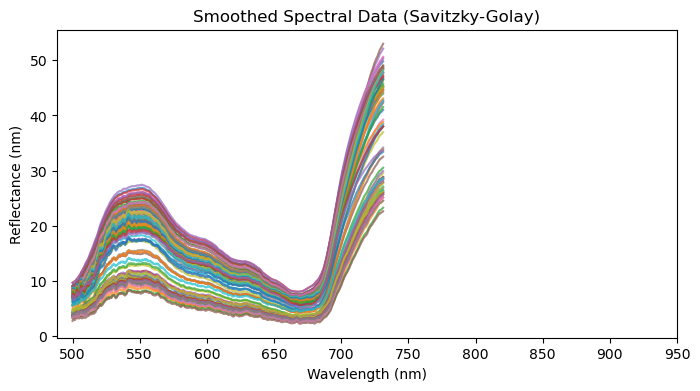

In [7]:
# Function to apply Savitzky-Golay smoothing
def savitzky_golay(X_selected, window_size=11, poly_order=2):
    return savgol_filter(X_selected, window_size, poly_order, axis=0)

# Apply Savitzky-Golay smoothing to X_selected
spectral_sgm = savitzky_golay(X_selected, window_size=11, poly_order=2)

# Create the wavelength range from 500nm to 950nm
wavelengths = np.arange(500, 951, 50)  # Wavelengths from 500nm to 950nm with 100nm intervals
num_columns = spectral_sgm.shape[1]


# Plot the spectral data
plt.figure(figsize=(8, 4))
plt.plot(spectral_sgm.T, alpha=0.7)

# Set x-axis labels to the wavelength values (500nm, 600nm, ..., 950nm)
plt.xticks(ticks=np.linspace(0, num_wavelengths-1, len(wavelengths)), labels=wavelengths)

# Add titles and labels
plt.title('Smoothed Spectral Data (Savitzky-Golay)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (nm)')

# Display the plot
plt.show()

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA

# Ensure X (features) and y (target) are passed
# Spectral_sgm contains spectral data (features)
# and cleaned_spad_data contains SPAD values (target)
#NOte
#X = spectral_sgm  # Independent variables (features)
#y = cleaned_spad_data  # Dependent variable (target)

# Splitting data into training (80%) and testing (20%) sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=175)
X_train, X_test, y_train, y_test = train_test_split(spectral_sgm, cleaned_spad_data, test_size=0.20, random_state=175)

# Now apply StandardScaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

# Apply ICA
ica = FastICA(n_components=12, max_iter=500, tol=0.01, random_state=175)
X_train_ica = ica.fit_transform(X_train_scaled)
X_test_ica = ica.transform(X_test_scaled)

# Print shape of transformed data
print(f"ICA-transformed training data shape: {X_train_ica.shape}")
print(f"ICA-transformed testing data shape: {X_test_ica.shape}")



ICA-transformed training data shape: (76, 12)
ICA-transformed testing data shape: (19, 12)


In [9]:

from scipy.stats import pearsonr
import numpy as np

# Pearson Correlation for Feature Selection
def select_features_pearson(X_train_ica, y_train, threshold=0.1):
    # Calculate Pearson correlation for each feature in X_train with y_train
    correlations = np.array([pearsonr(X_train_ica[:, i], y_train)[0] for i in range(X_train_ica.shape[1])])
    
    # Select indices of features with absolute correlation greater than threshold
    selected_features = np.where(np.abs(correlations) > threshold)[0]
    
    # Return the filtered training set and the indices of selected features
    return X_train_ica[:, selected_features], selected_features

# Apply Pearson Correlation for Feature Selection
threshold = 0.1  # Adjust the threshold as needed
X_train_pearson, selected_features = select_features_pearson(X_train_ica, y_train, threshold)

# Apply the same feature selection to X_test
X_test_pearson = X_test_ica[:, selected_features]

# Output
print(f"Number of features selected by Pearson correlation: {len(selected_features)}")
print("Selected features indices (Pearson):", selected_features)

Number of features selected by Pearson correlation: 11
Selected features indices (Pearson): [ 1  2  3  4  5  6  7  8  9 10 11]


In [10]:
# Define parameter grids for RandomizedSearchCV
n_estimators = np.arange(3,100,9)
learning_rate = np.arange(0.01, 1, 0.09)
max_depth = np.arange(2, 40,3)

param_dist_gb = {
   'n_estimators': n_estimators,
   'learning_rate': learning_rate,
   'max_depth': max_depth
}

# Initialize models
model_gb = GradientBoostingRegressor(random_state=175)

# Perform RandomizedSearchCV for each model
random_search_gb = RandomizedSearchCV(model_gb, param_distributions=param_dist_gb, n_iter=48, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=175, error_score='raise')
random_search_gb.fit(X_train_pearson, y_train)
best_gb = random_search_gb.best_estimator_
best_params_gb = random_search_gb.best_params_
print("Best parameters for Gradient Boosting: ", best_params_gb)
# Cross-validation with the best hyperparameters for each model
mse_scores_gb = cross_val_score(best_gb, X_train_pearson, y_train, scoring='neg_mean_squared_error', cv=5)

# Convert negative MSE to positive MSE and calculate the average MSE
mse_scores_gb = -mse_scores_gb
average_mse_gb = np.mean(mse_scores_gb)
# Print cross-validation results
print(f"Average MSE for Gradient Boosting: {average_mse_gb}")
# Evaluate the individual models
models = {
    "GradientBoosting": best_gb
    }
# Function to calculate evaluation metrics including Pearson correlation
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rpd = np.std(y_true) / rmse
    pearson_corr, _ = pearsonr(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "RPD": rpd, "Pearson": pearson_corr}

# Evaluate individual models
metrics_train = {}
metrics_test = {}

for name, model in models.items():
    print(f"Evaluating {name} model...")
    model.fit(X_train_pearson, y_train)
    
    y_train_pred = model.predict(X_train_pearson)
    y_test_pred = model.predict(X_test_pearson)
    
    if y_train_pred.ndim > 1:  # Ensure predictions have the correct shape
        y_train_pred = y_train_pred.ravel()
    if y_test_pred.ndim > 1:
        y_test_pred = y_test_pred.ravel()
    
    metrics_train[name] = calculate_metrics(y_train, y_train_pred)
    metrics_test[name] = calculate_metrics(y_test, y_test_pred)

print("Training Metrics:")
print(pd.DataFrame(metrics_train).T)
print("\nTesting Metrics:")
print(pd.DataFrame(metrics_test).T)

Best parameters for Gradient Boosting:  {'n_estimators': 75, 'max_depth': 2, 'learning_rate': 0.09999999999999999}
Average MSE for Gradient Boosting: 20.580543149471943
Evaluating GradientBoosting model...
Training Metrics:
                       MAE       MSE   Pearson        R2      RMSE       RPD
GradientBoosting  1.067663  1.829651  0.985228  0.953418  1.352646  4.633298

Testing Metrics:
                       MAE        MSE   Pearson        R2      RMSE       RPD
GradientBoosting  2.939354  16.633863  0.872118  0.633103  4.078463  1.650928


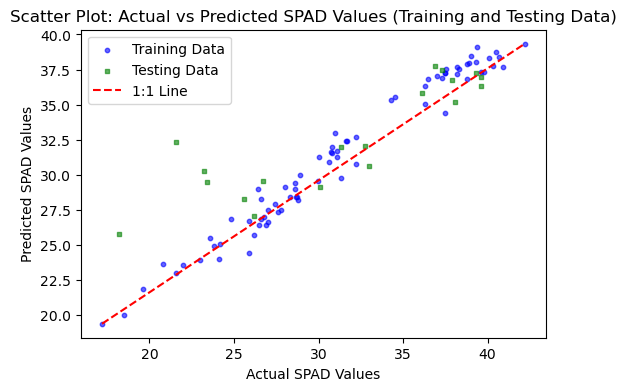

In [11]:
import matplotlib.pyplot as plt

# Assuming these are your actual and predicted SPAD values for both training and testing sets
y_train_actual = y_train # Replace with your actual training SPAD values
y_train_predicted = y_train_pred # Replace with your predicted SPAD values from the model (training)

y_test_actual = y_test  # Replace with your actual testing SPAD values
y_test_predicted = y_test_pred  # Replace with your predicted SPAD values from the model (testing)

# Combined Plot
plt.figure(figsize=(6, 4))

# Scatter plot for Training Data (circles)
plt.scatter(y_train_actual, y_train_predicted, color='blue', alpha=0.6, s=10, marker='o', label='Training Data')

# Scatter plot for Testing Data (squares)
plt.scatter(y_test_actual, y_test_predicted, color='green', alpha=0.6, s=10, marker='s', label='Testing Data')

# Plot the 1:1 line (perfect prediction)
plt.plot([min(min(y_train_actual), min(y_test_actual)), max(max(y_train_actual), max(y_test_actual))],
         [min(min(y_train_predicted), min(y_test_predicted)), max(max(y_train_predicted), max(y_test_predicted))],
         color='red', linestyle='--', label='1:1 Line')

# Labels and title
plt.xlabel('Actual SPAD Values', fontsize=10)
plt.ylabel('Predicted SPAD Values', fontsize=10)
plt.title('Scatter Plot: Actual vs Predicted SPAD Values (Training and Testing Data)', fontsize=12)

# Add legend
plt.legend()

# Remove grid and display plot
plt.show()

